In [1]:
# Importing and installing needed packages
import cv2
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pdf2image import convert_from_path, convert_from_bytes

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
# Importing pdf files
os.chdir(r'C:\Users\JosipKoprcina\Desktop\AnalysisOfSpeechBubblesAtDifferentMangaArcPoints\data')
myFiles = glob.glob('*.pdf')

chapters = []
myFiles = myFiles[:10]

for file in myFiles:
    images = convert_from_path(file, fmt='jpg')
    chapters.append(images)
    
path = os.getcwd()

for i in range(len(chapters)):
    chapter_path = path + '\\' + myFiles[i][:-3]
    os.mkdir(chapter_path)
    os.chdir(chapter_path)
    for j in range(len(chapters[i])):
        if(j > 0 and j < 10):
            chapters[i][j].save(myFiles[i][:-4] + ' 0' + str(j) + '.png', 'PNG')
        elif(j > 9):
            chapters[i][j].save(myFiles[i][:-4] + ' ' + str(j) + '.png', 'PNG')

In [3]:
os.chdir(r'C:\Users\JosipKoprcina\Desktop\AnalysisOfSpeechBubblesAtDifferentMangaArcPoints')
data_dir = "./data/"
chapters = []
for chapter_name in os.listdir(data_dir):
    chapter = []
    if(chapter_name[-4:] != ".pdf"):
        for image_name in os.listdir(data_dir + chapter_name):
            chapter.append(os.path.join(data_dir + chapter_name, image_name))
    chapters.append(chapter)

In [4]:
def preprocess_image(in_image, visualize=False):
    out_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2GRAY)
    out_image = cv2.adaptiveThreshold(out_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 75, 10)
    out_image = cv2.erode(out_image, np.ones((3,3)), iterations = 1)

    if visualize:
        fig, axes = plt.subplots(ncols=2, figsize=(15,10))
        axes[0].imshow(in_image)
        axes[0].set_title('Original image')
        axes[1].imshow(out_image, cmap='gray')
        axes[1].set_title('Preprocessed image')
    
    return out_image

In [5]:
def connected_components(image, iom_threshold=0.7, offset = 10, visualize=False):
    box_stats = cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S)[2]
    box_area = box_stats[:, 4]
    
    l, w = image.shape
    area_condition = (box_area > l*w/20**2) & (box_area < l*w/7**2)
    filtered_stats = box_stats[area_condition]
    
    box_candidates = []  
    for x,y,w,h in filtered_stats[:, :4]:
        box_candidates.append((y-offset, y+h+offset, x-offset, x+w+offset))

    if visualize:
        # Messy grid visualization of box_candidates
        nrows, ncols = 5, int(len(box_candidates)/5) + 1
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        ix = 0
        for row in axes:
            for col in row: 
                if ix < len(box_candidates):
                    pts = box_candidates[ix]
                    y0,y1,x0,x1 = pts
                    col.imshow(image[y0:y1,x0:x1], cmap='gray')
                col.get_xaxis().set_ticks([])
                col.get_yaxis().set_ticks([])
                ix += 1
        plt.show()
    
    return box_candidates

In [6]:
def getContourStat(contour,image):
    mask = np.zeros(image.shape,dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    mean,stddev = cv2.meanStdDev(image,mask=mask)
    return mean

def bubble_contours(image, box_candidates, iom_threshold = 0.5, convexify = False, visualize = False):   
    draw_mask = np.zeros_like(image)
      
    box_stats = []
    for y0,y1,x0,x1 in box_candidates:
        # Find contours of speech bubbles in connected components (rectangular boxes)
        mask = np.zeros_like(image)
        mask[y0:y1,x0:x1] = image[y0:y1,x0:x1]
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:3]
        for cnt in cnts:
            approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt,True), True)

            # Check pixel intensity and discard those lying outside normal (heuristic) range
            if getContourStat(cnt, image) > 240 or getContourStat(cnt, image) < 100:
                continue
                
            x,y,w,h = cv2.boundingRect(cnt)
            cnt_area = cv2.contourArea(cnt)
            circle_radius = cv2.minEnclosingCircle(cnt)[1]
            circle_area_ratio = int(3.14 * circle_radius**2 / (cnt_area + 1e-6))
            rect_area_ratio = int(w*h/cnt_area)
            # This is a speech "bubble" heuristic, it should also work for boxes
            # The basic idea is that a bubbles area should approximate that of an enclosing circle
            if ((circle_area_ratio <= 2) & (cnt_area > 4000)) or (rect_area_ratio == 1):
                if convexify: 
                    approx = cv2.convexHull(approx)
                box_stats.append((approx, (y,y+h,x,x+w)))
                cv2.fillPoly(draw_mask, [approx], (255,255,255))
                
    if visualize:
        fig, ax = plt.subplots(ncols=2, figsize = (20,10))
        ax[0].imshow(draw_mask, cmap='gray')
        ax[1].imshow(image, cmap='gray')
        plt.tight_layout()
    
    
    return draw_mask

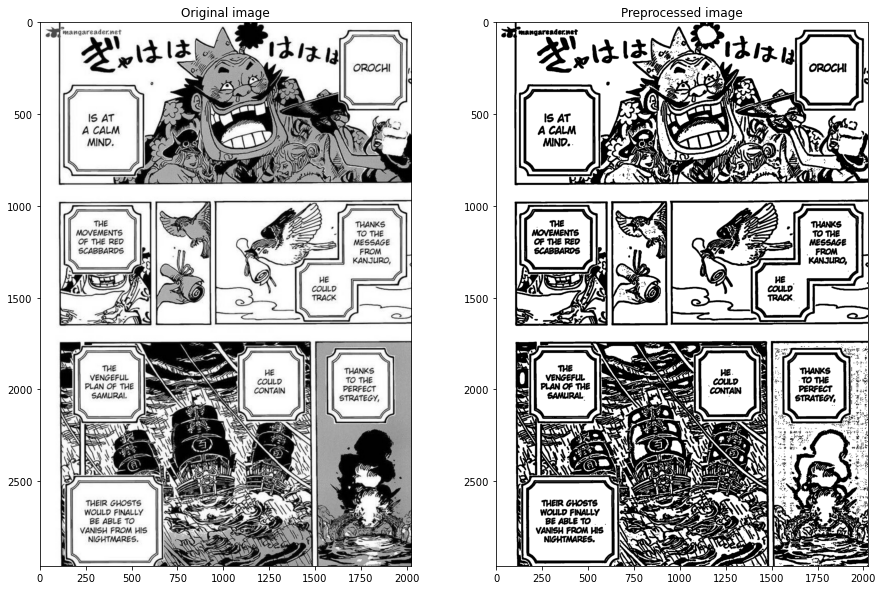

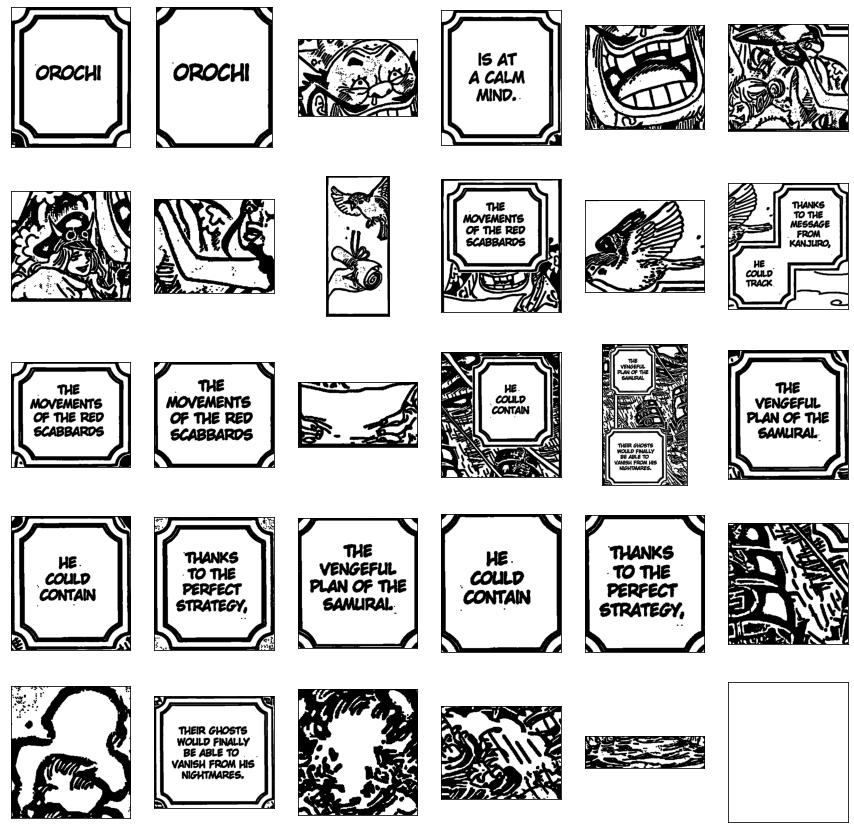

<ipython-input-5-9e1d215ec9f1>:24: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  col.imshow(image[y0:y1,x0:x1], cmap='gray')
<ipython-input-5-9e1d215ec9f1>:24: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  col.imshow(image[y0:y1,x0:x1], cmap='gray')


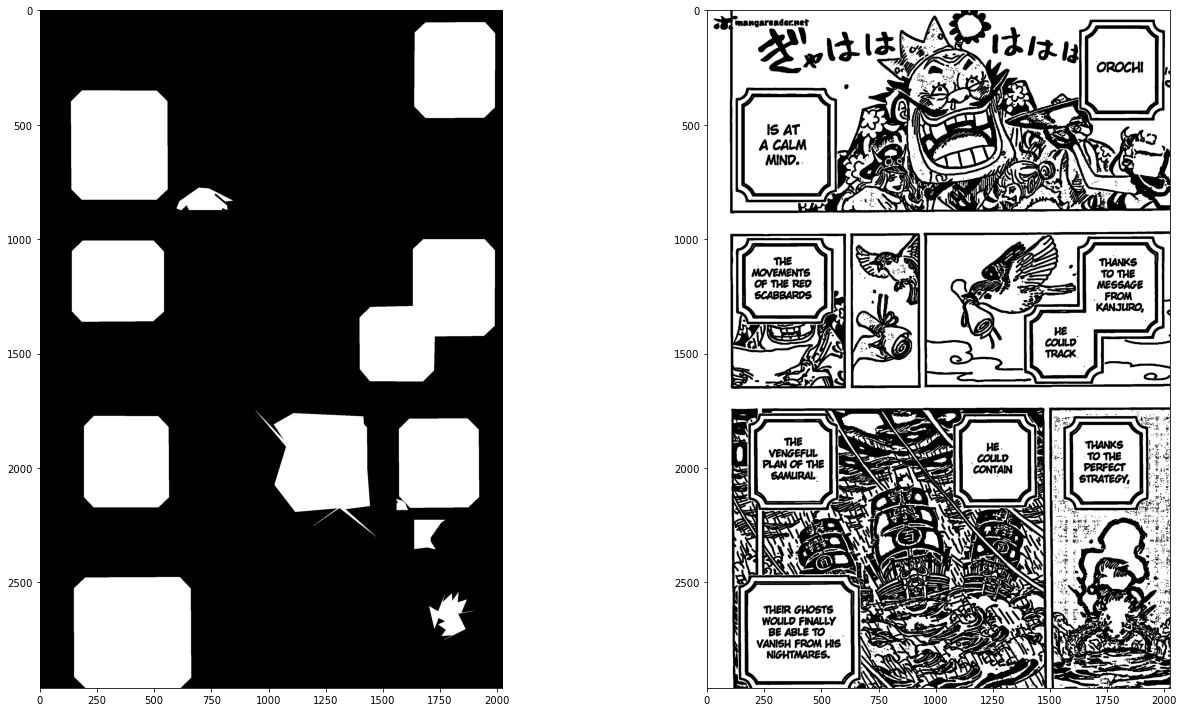

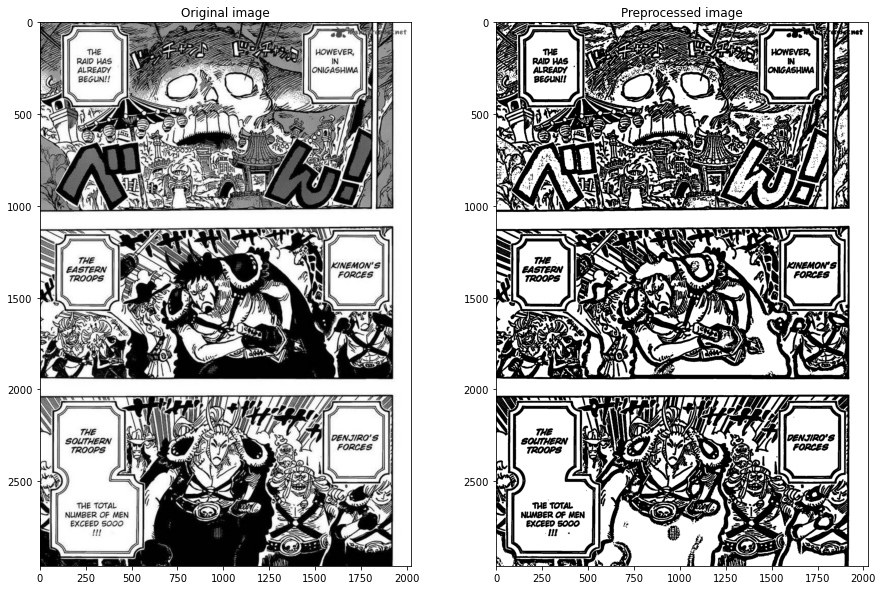

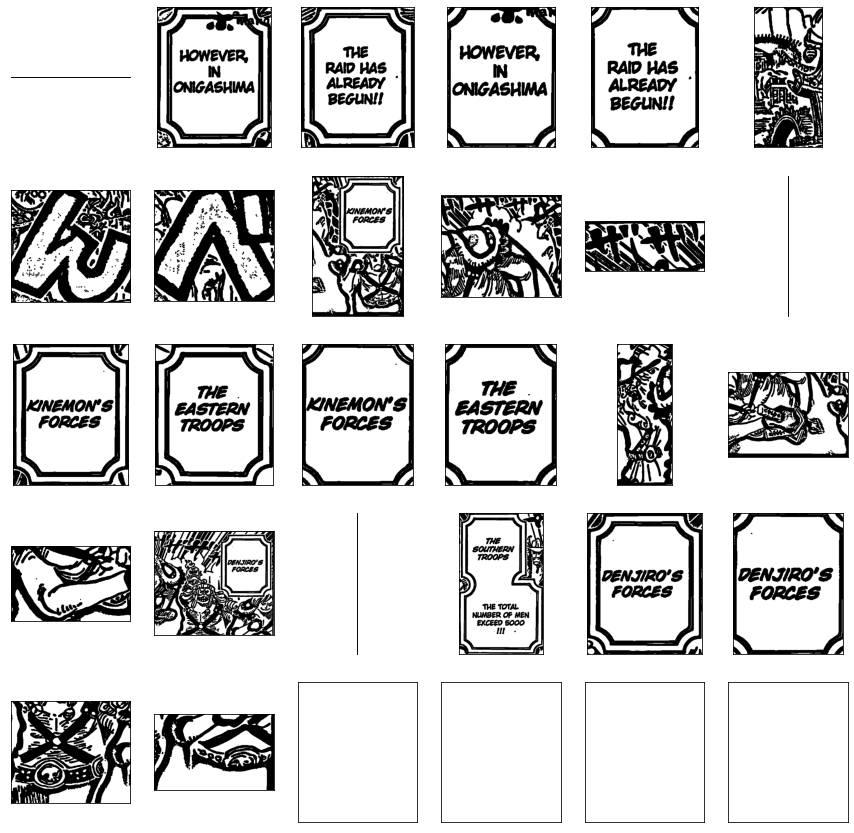

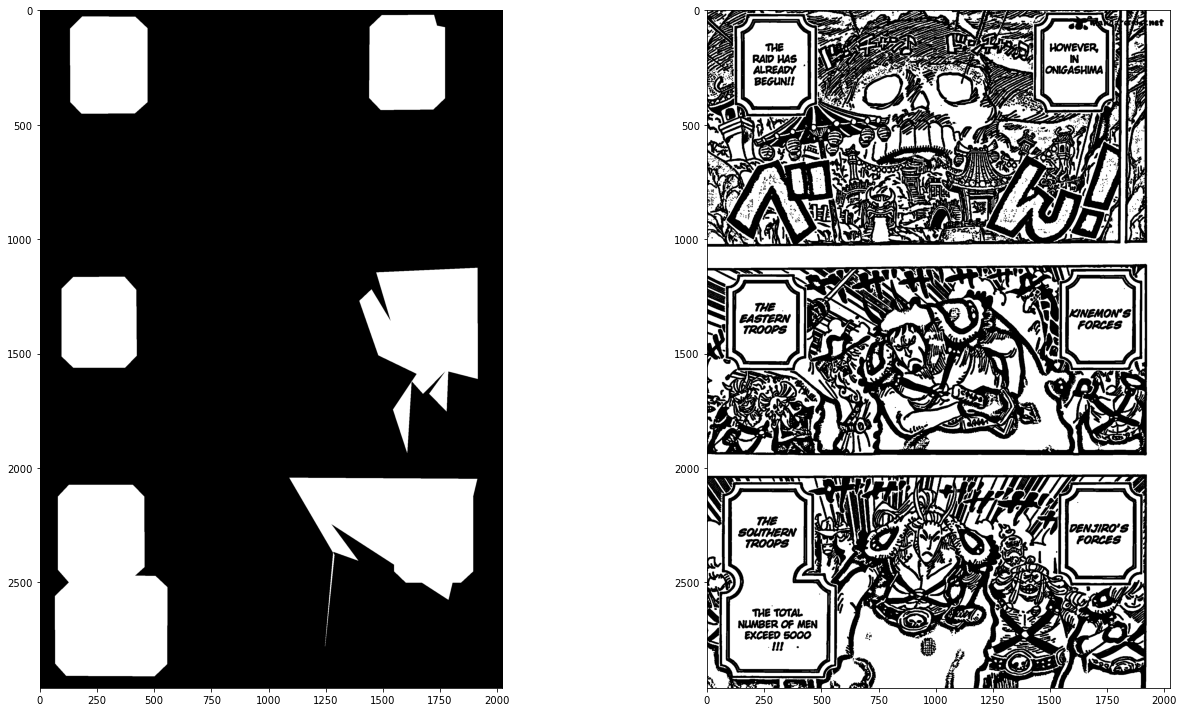

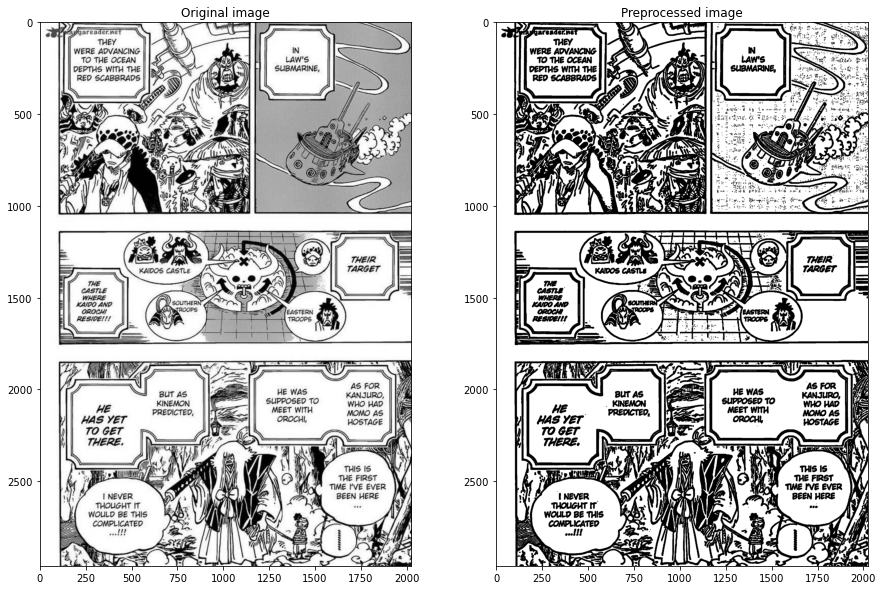

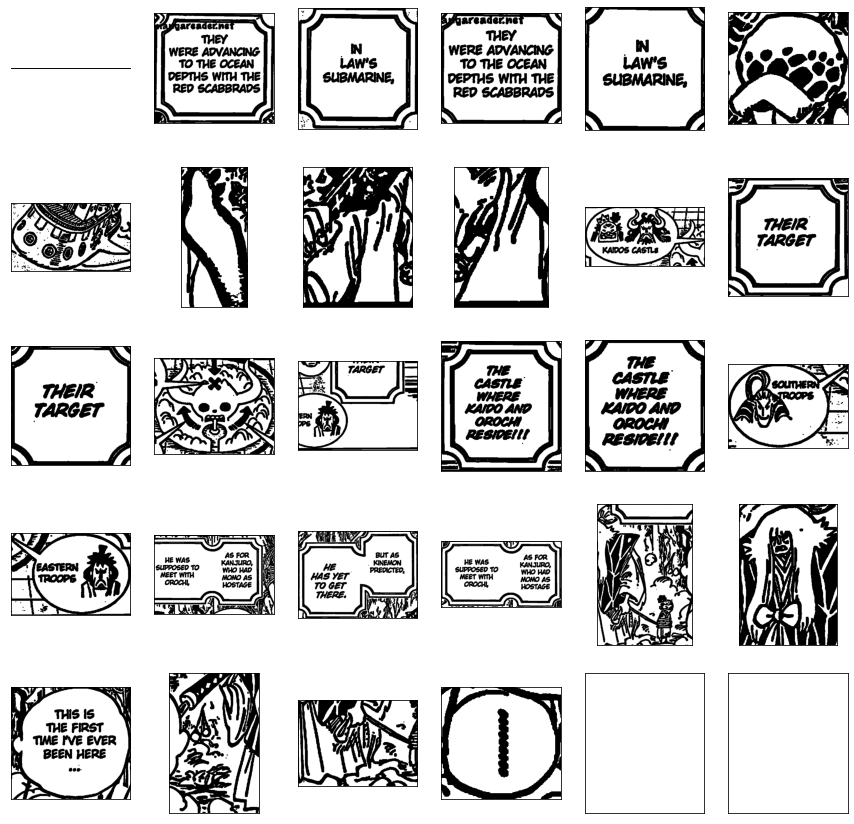

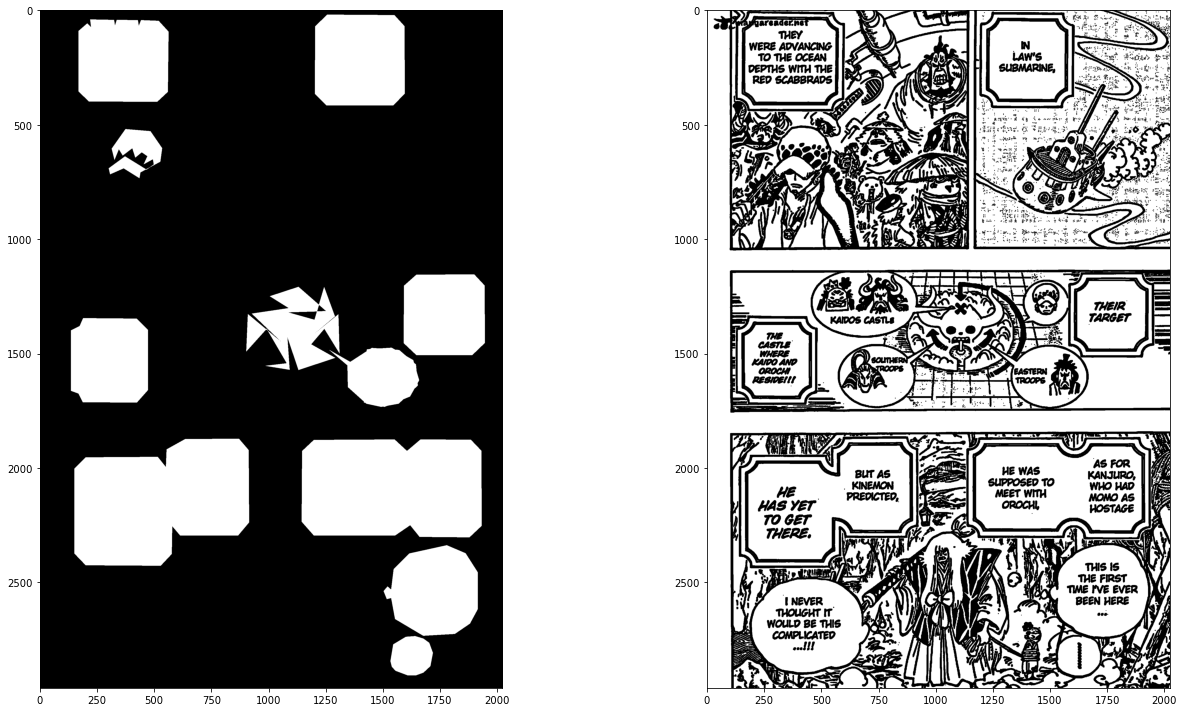

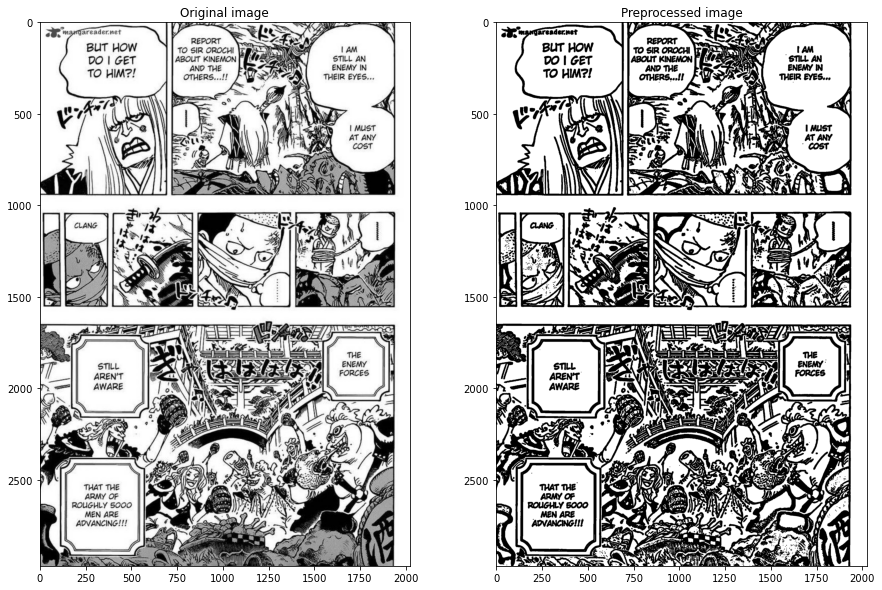

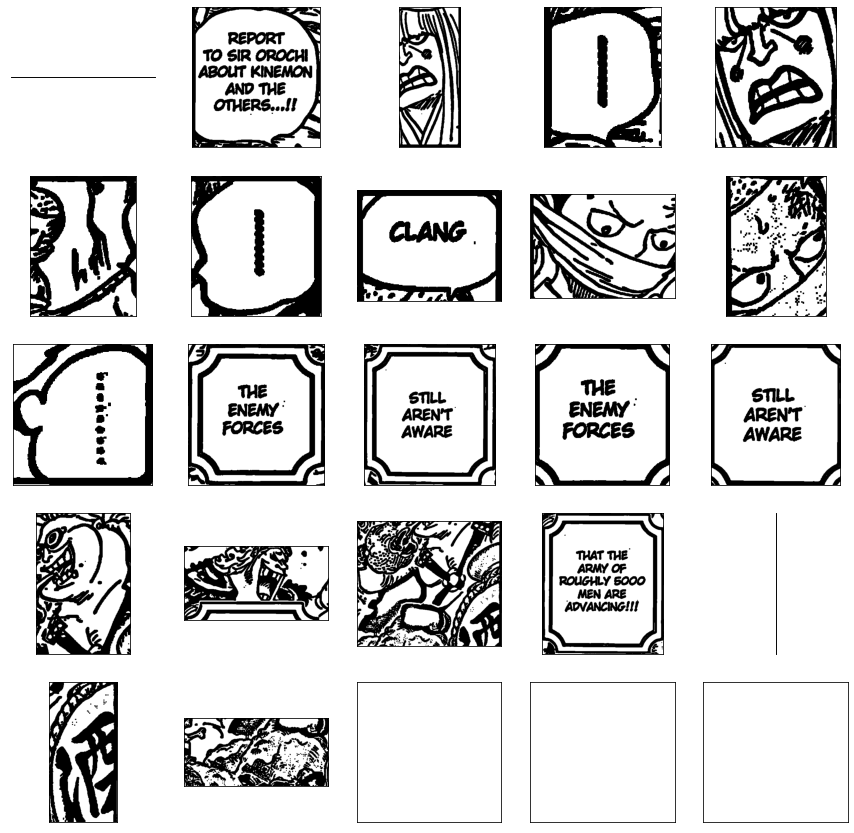

KeyboardInterrupt: 

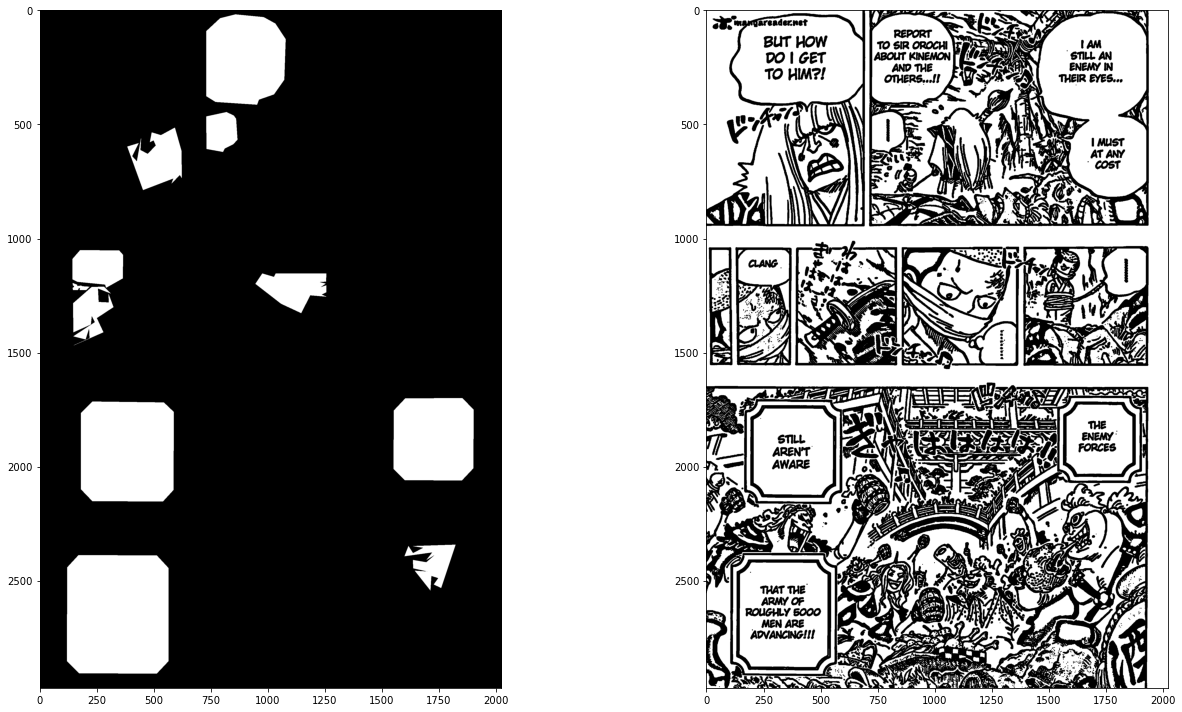

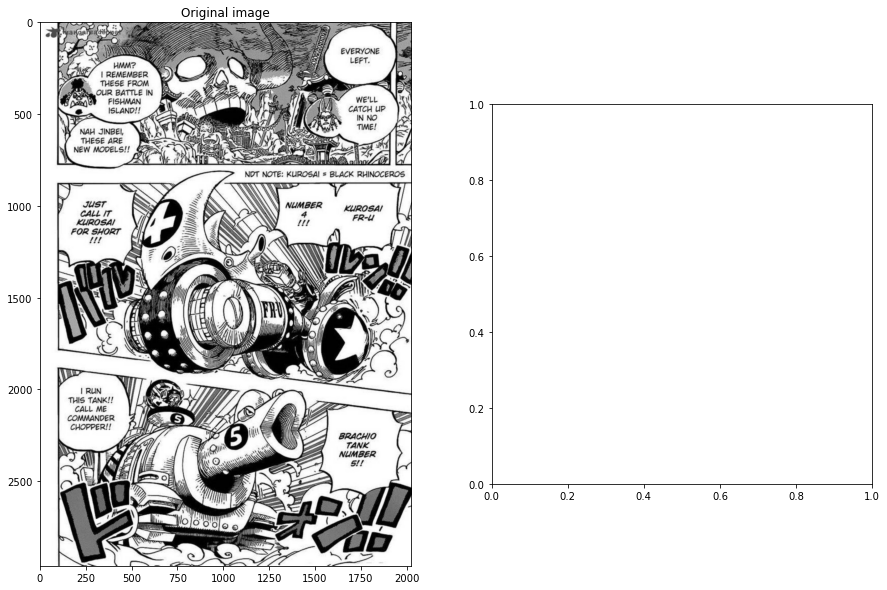

In [7]:
for i in range(len(chapters)):
    for j in range(len(chapters[i])):
        original_image = cv2.imread(chapters[i][j])
        image = preprocess_image(original_image, visualize=True)
        box_candidates = connected_components(image, visualize=True)
        draw_mask = bubble_contours(image, box_candidates, visualize=True)
        if(j < 10):
            np.save(chapters[i][j][:-7] + '_grey_scale 0' + str(j) + ".png", draw_mask)
        else:
            np.save(chapters[i][j][:-7] + '_grey_scale ' + str(j) + ".png", draw_mask)